In [ ]:
from typing import List

import numpy as np
import tensorflow as tf
import h5py
import os
from tensorflow.keras.utils import to_categorical
from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from typing import Tuple, Dict, Any, Sequence

from collections import defaultdict
import tensorflow as tf

CD into the directory where the test and training datasets are located

In [ ]:
%cd drive/MyDrive/SCA-Datasets/

/content/drive/MyDrive/SCA-Datasets


In [ ]:
# start with train
dataset_name = "training_0"
shard = []
attack_byte = 0
attack_point = "sub_bytes_in"
max_trace_length = 5000
num_traces = 256
num_traces_per_shard = 256
full_key = False
x_List: List[Tensor] = []
y_List: List[Tensor] = []

#Opening the hdf5 file and creating x and y train.
with (h5py.File(f"{dataset_name}.hdf5", "r")) as f:
    for group in f.keys():
        group_name = f[group]

        x_shard = group_name["traces"][:num_traces_per_shard, :5000, :]
        x_shard = tf.convert_to_tensor(x_shard, dtype="float32")

        y_shard = group_name["sub_bytes_in"][attack_byte]
        y_shard = y_shard[:num_traces_per_shard]
        y_shard = to_categorical(y_shard, 256)
        y_shard = tf.convert_to_tensor(y_shard, dtype="uint8")

        x_List.append(x_shard)
        y_List.append(y_shard)
    x: Tensor = tf.concat(x_List, axis=0)
    y: Tensor = tf.concat(y_List, axis=0)
x_train = x
y_train = y

#Do the same for the test dataset
dataset_name = "test_0"
shard = []
attack_byte = 0
attack_point = "sub_bytes_in"
max_trace_length = 5000
num_traces = 256
num_traces_per_shard = 256
full_key = False
x_List: List[Tensor] = []
y_List: List[Tensor] = []


with (h5py.File(f"{dataset_name}.hdf5", "r")) as f:
    for group in f.keys():
        group_name = f[group]

        x_shard = group_name["traces"][:num_traces_per_shard, :5000, :]
        x_shard = tf.convert_to_tensor(x_shard, dtype="float32")

        y_shard = group_name["sub_bytes_in"][attack_byte]
        y_shard = y_shard[:num_traces_per_shard]
        y_shard = to_categorical(y_shard, 256)
        y_shard = tf.convert_to_tensor(y_shard, dtype="uint8")

        x_List.append(x_shard)
        y_List.append(y_shard)
    x: Tensor = tf.concat(x_List, axis=0)
    y: Tensor = tf.concat(y_List, axis=0)
x_test = x
y_test = y

This need to point at the location of the saved parameter from keras search.

In [ ]:
import json
import os
my_dir = "my_dir"
best_hyperparameters_file = os.path.join(my_dir, "best_hyperparameters.json")
try:
  with open(best_hyperparameters_file, 'r') as f:
    best_hyperparameters = json.load(f)

    # Create a new dictionary with the desired structure
    restructured_config = {
        "model": "cnn",
        "device": "stm32f0",
        "algorithm": "tinyaes",
        "version": "1",
        "attack_points": ["sub_bytes_in"],
        "attack_bytes": ["0"],
        "max_trace_len": 5000,
        "num_shards": 256,
        "num_traces_per_shard": 256,
        "batch_size": 32,
        "epochs": 30,
        "optimizer_parameters": {
            "lr": best_hyperparameters.get("lr"),  # Get lr from best_hyperparameters or default to 0.001
            "multi_gpu_lr": best_hyperparameters.get("multi_gpu_lr")  # Get multi_gpu_lr or default to 0.001
        },
        "model_parameters": {
            "activation": best_hyperparameters.get("activation"),  # Get activation or default to "relu"
            "initial_filters": best_hyperparameters.get("initial_filters"),  # Get initial_filters or default to 8
            "initial_pool_size": best_hyperparameters.get("initial_pool_size"),  # Get initial_pool_size or default to 4
            "block_kernel_size": best_hyperparameters.get("block_kernel_size"),  # Get block_kernel_size or default to 3
            "blocks_stack1": best_hyperparameters.get("blocks_stack1"),  # Get blocks_stack1 or default to 3
            "blocks_stack2": best_hyperparameters.get("blocks_stack2"),  # Get blocks_stack2 or default to 4
            "blocks_stack3": best_hyperparameters.get("blocks_stack3"),  # Get blocks_stack3 or default to 4
            "blocks_stack4": best_hyperparameters.get("blocks_stack4"),  # Get blocks_stack4 or default to 3
            "dense_dropout": best_hyperparameters.get("dense_dropout"),  # Get dense_dropout or default to 0.1
            "use_pooling": best_hyperparameters.get("use_pooling")  # Get use_pooling or default to True
        }
    }

    # Print the restructured config
    print(json.dumps(restructured_config, indent=4))
except FileNotFoundError:
  print(f"Error: File not found at {best_hyperparameters_file}")
except json.JSONDecodeError:
  print(f"Error: Invalid JSON format in {best_hyperparameters_file}")

# You can then save this restructured_config to a new JSON file if needed:
with open("Best_hyperparam_reconfig.json", "w") as f:
    json.dump(restructured_config, f, indent=4)

{
    "model": "cnn",
    "device": "stm32f0",
    "algorithm": "tinyaes",
    "version": "1",
    "attack_points": [
        "sub_bytes_in"
    ],
    "attack_bytes": [
        "0"
    ],
    "max_trace_len": 5000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.00010283965194405868,
        "multi_gpu_lr": null
    },
    "model_parameters": {
        "activation": "tanh",
        "initial_filters": 8,
        "initial_pool_size": 2,
        "block_kernel_size": 13,
        "blocks_stack1": 6,
        "blocks_stack2": 2,
        "blocks_stack3": 5,
        "blocks_stack4": 6,
        "dense_dropout": 0.45,
        "use_pooling": false
    }
}


In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Intro model."""

from typing import Any, Dict, Tuple

from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#from scaaml.utils import display_config
def display_config(config_name: str, config: Dict[str, str]) -> None:
    """Pretty print a config object in terminal.

    Args:
        config_name (str): name of the config
        config (dict): config to display
    """
    cprint(f"[{config_name}]", "magenta")
    cnt = 1
    for k, v in config.items():
        color: Color = "yellow"
        if cnt % 2:
            color = "cyan"
        cprint(f"{k}:{v}", color)
        cnt += 1
#from scaaml.utils import get_num_gpu
def get_num_gpu() -> int:
    return len(tf.config.list_physical_devices("GPU"))

# pylint: disable=too-many-positional-arguments
def block(x: Tensor,
          filters: int,
          kernel_size: int = 3,
          strides: int = 1,
          conv_shortcut: bool = False,
          activation: str = "relu") -> Tensor:
    """Residual block with pre-activation
    From: https://arxiv.org/pdf/1603.05027.pdf

    Args:
        x: input tensor.
        filters (int): filters of the bottleneck layer.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride of the first layer.
        defaults to 1.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        use_batchnorm (bool, optional): Use batchnormalization if True.
        Defaults to True.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        Output tensor for the residual block.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    if conv_shortcut:
        shortcut = layers.Conv1D(4 * filters, 1, strides=strides)(x)
    else:
        if strides > 1:
            shortcut = layers.MaxPooling1D(1, strides=strides)(x)
        else:
            shortcut = x

    x = layers.Conv1D(filters, 1, use_bias=False, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(filters,
                      kernel_size,
                      strides=strides,
                      use_bias=False,
                      padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(4 * filters, 1)(x)
    x = layers.Add()([shortcut, x])
    return x


# pylint: disable=too-many-positional-arguments
def stack(x: Tensor,
          filters: int,
          blocks: int,
          kernel_size: int = 3,
          strides: int = 2,
          activation: str = "relu") -> Tensor:
    """A set of stacked residual blocks.
    Args:
        filters (int): filters of the bottleneck layer.

        blocks (int): number of conv blocks to stack.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride used in the last block.
        defaults to 2.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        tensor:Output tensor for the stacked blocks.
  """
    x = block(x,
              filters,
              kernel_size=kernel_size,
              activation=activation,
              conv_shortcut=True)
    for _ in range(2, blocks):
        x = block(x, filters, kernel_size=kernel_size, activation=activation)
    x = block(x, filters, strides=strides, activation=activation)
    return x


from typing import Any, Dict, Tuple
from tensorflow.keras.models import Model


# pylint: disable=C0103
def Resnet1D(input_shape: Tuple[int, ...], attack_point: str,
             mdl_cfg: Dict[str, Any], optim_cfg: Dict[str,
                                                      Any]) -> Model:
    del attack_point  # unused

    pool_size = mdl_cfg["initial_pool_size"]
    filters = mdl_cfg["initial_filters"]
    block_kernel_size = mdl_cfg["block_kernel_size"]
    activation = mdl_cfg["activation"]
    dense_dropout = mdl_cfg["dense_dropout"]
    num_blocks = [
        mdl_cfg["blocks_stack1"], mdl_cfg["blocks_stack2"],
        mdl_cfg["blocks_stack3"], mdl_cfg["blocks_stack4"]
    ]

    inputs = layers.Input(shape=input_shape)
    x = inputs

    # stem endring, VÅRT DATASETT ER IKKE OVERSAMPLET
    if mdl_cfg.get("use_pooling", True):
      x = layers.MaxPool1D(pool_size=pool_size)(x)

    # trunk: stack of residual block
    for block_idx in range(4):
        filters *= 2
        x = stack(x,
                  filters,
                  num_blocks[block_idx],
                  kernel_size=block_kernel_size,
                  activation=activation)

    # head model: dense
    x = layers.GlobalAveragePooling1D()(x)
    for _ in range(1):
        x = layers.Dropout(dense_dropout)(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

    outputs = layers.Dense(256, activation="softmax")(x)

    model: Model[Any, Any] = Model(inputs=inputs, outputs=outputs)
    model.summary()

    if get_num_gpu() > 1:
        lr = optim_cfg["multi_gpu_lr"]
    else:
        lr = optim_cfg["lr"]

    model.compile(loss=["categorical_crossentropy"],
                  metrics=["acc"],
                  optimizer=Adam(lr))
    return model



In [ ]:
input_shape = x_train.shape[1:]
attack_point = "sub_bytes_in"

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt


# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

# Create an EarlyStopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

#Create a ModelCheckpoint to store the best model
checkpoint_callback = ModelCheckpoint(filepath='best_model_v1.keras', monitor='val_loss', save_best_only=True)

Might need a way to load the wanted model if we want to train more than one, or do it above?

In [ ]:
model = Resnet1D(input_shape, attack_point, restructured_config["model_parameters"], restructured_config["optimizer_parameters"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5000, 1)   │          4 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 5000, 1)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5000, 16)  │         16 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 5000, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5000, 16)  │      3,328 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 16)  │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 5000, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5000, 64)  │        128 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5000, 64)  │      1,088 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5000, 64)  │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 64)  │        256 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 5000, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5000, 16)  │      1,024 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 16)  │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 5000, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5000, 16)  │      3,328 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 16)  │         64 │ conv1d_5[0][0]  

 Total params: 2,712,212 (10.35 MB)

 Trainable params: 2,697,746 (10.29 MB)

 Non-trainable params: 14,466 (56.51 KB)

In [ ]:
#CD into the directory we want to store data about models, which is models
%cd SCA-Datasets/models

/content/drive/MyDrive/SCA-Datasets/models


In [ ]:
#removing early stopping because we know it will perfom better at epoch 20
history = model.fit(x_train,
                       y_train,
                       epochs=restructured_config['epochs'],
                       batch_size=restructured_config['batch_size'],
                       validation_data=(x_test, y_test),
                       callbacks=[tensorboard_callback, checkpoint_callback],
                       verbose=1)

Epoch 1/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 100s 49ms/step - acc: 0.2921 - loss: 2.4758 - val_acc: 0.2323 - val_loss: 2.7760
Epoch 2/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 100s 49ms/step - acc: 0.3254 - loss: 2.3305 - val_acc: 0.3217 - val_loss: 2.3376
Epoch 3/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 100s 49ms/step - acc: 0.3527 - loss: 2.2103 - val_acc: 0.3360 - val_loss: 2.2614
Epoch 4/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 100s 49ms/step - acc: 0.3807 - loss: 2.1004 - val_acc: 0.1795 - val_loss: 3.3149
Epoch 5/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - acc: 0.4032 - loss: 2.0049 - val_acc: 0.1391 - val_loss: 4.1234
Epoch 6/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - acc: 0.4161 - loss: 1.9457 - val_acc: 0.2350 - val_loss: 2.8410
Epoch 7/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - acc: 0.4306 - loss: 1.8914 - val_acc: 0.2888 - val_loss: 2.4867
Epoch 8/30
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 100s 49ms/step - acc: 0.4474 - loss: 1.8230 - val_acc: 0.3824 - val_loss: 2.0751
Epoch 9/30
2048/204

In [ ]:
import pickle

# Save the history object to a file
with open('train_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

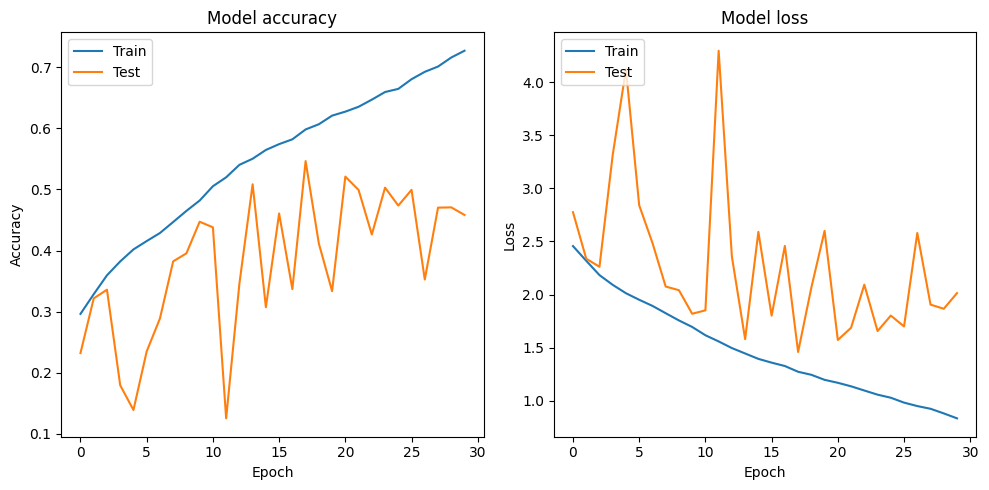

In [ ]:
# prompt: Look at the history data

import matplotlib.pyplot as plt


# Load the history data from the pickle file
with open('train_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()
